In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [37]:
K = keras.backend
class ExponLR(keras.callbacks.Callback):
    def __init__(self, factor, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
        self.rates = []
        self.losses = []
    
    def on_train_batch_end(self, batch, logs=None):
        rate = K.get_value(self.model.optimizer.lr)
        new_rate = rate * self.factor
        
        K.set_value(self.model.optimizer.lr, new_rate)
        
        self.losses.append(logs['loss'])
        self.rates.append(rate)

In [67]:
def make_model(lr=1e-3):
    model = keras.models.Sequential([
        keras.layers.Input([28,28]),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(500,activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(500,activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax'),
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(lr=lr),
                  metrics=['accuracy'],
                 )
    return model

In [70]:
min_lr = 1e-3
max_lr = 1e0
bs = 64
model = make_model(lr=min_lr)
iters = len(x_train) // bs
factor = (max_lr/min_lr) ** (1/iters)
exponlr_cb = ExponLR(factor)
model.fit(x_train, y_train,
          epochs=1,
          batch_size=bs,
          callbacks=[exponlr_cb]
         )
rates, losses = exponlr_cb.rates, exponlr_cb.losses

Train on 60000 samples
60000/60000 [==============================] - 25s 410us/sample - loss: 135.6814 - accuracy: 0.5296


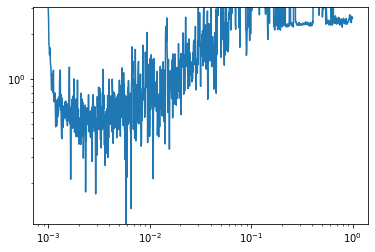

In [71]:
# plt.plot(rates, losses)
# plt.gca().set_xscale('log')
plt.loglog(rates, losses)
plt.ylim([min(losses), (losses[0] + min(losses))])
plt.show()

In [76]:
keras.backend.clear_session()

# model = make_model(lr=1e-3)
model = keras.models.load_model('models/10_lecture/mnist_stage_1.h5')
K.set_value(model.optimizer.lr, 1e-3)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                 monitor='val_accuracy',
                                                restore_best_weights=True)
reducelr_cb = keras.callbacks.ReduceLROnPlateau(patience=5,
                                               monitor='val_accuracy'
                                               )
chkpoint_cb = keras.callbacks.ModelCheckpoint('models/10_lecture/mnist_stage_2.h5',
                                               monitor='val_accuracy',
                                               save_best_only=True)
model.fit(x_train, y_train,
          epochs=40,
          validation_split=0.1,
          batch_size=64,
          callbacks=[earlystopping_cb,reducelr_cb,chkpoint_cb],)

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 24s 439us/sample - loss: 0.2479 - accuracy: 0.9365 - val_loss: 1.1791 - val_accuracy: 0.9753
Epoch 2/40
54000/54000 [==============================] - 23s 424us/sample - loss: 0.2194 - accuracy: 0.9451 - val_loss: 0.8045 - val_accuracy: 0.9742
Epoch 3/40
54000/54000 [==============================] - 24s 446us/sample - loss: 0.2127 - accuracy: 0.9487 - val_loss: 2.4711 - val_accuracy: 0.9767
Epoch 4/40
54000/54000 [==============================] - 25s 457us/sample - loss: 0.2029 - accuracy: 0.9507 - val_loss: 1.0569 - val_accuracy: 0.9777
Epoch 5/40
54000/54000 [==============================] - 25s 458us/sample - loss: 0.2108 - accuracy: 0.9512 - val_loss: 2.3502 - val_accuracy: 0.9780
Epoch 6/40
54000/54000 [==============================] - 25s 454us/sample - loss: 0.2028 - accuracy: 0.9533 - val_loss: 1.0848 - val_accuracy: 0.9802
Epoch 7/40
54000/54000 [=====================

In [78]:
model = keras.models.load_model('models/10_lecture/mnist_stage_2.h5')
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 3s 298us/sample - loss: 4.8638 - accuracy: 0.9778


[4.863849951326185, 0.9778]